In [7]:
import importlib.util

if importlib.util.find_spec("regex") is None:
    !pip install regex

if importlib.util.find_spec("graphviz") is None:
    !pip install graphviz

In [8]:
import os
import re

TARGET_DIR = [
    "./../../FUSOU-PROXY-DATA/kcsapi/",
    "./../../../../FUSOU_TEST_DATA/FUSOU-PROXY-DATA~202504290219/kcsapi/",
    "./../../../../FUSOU_TEST_DATA/FUSOU-PROXY-DATA~202506030524/kcsapi/",
    "./../../../../FUSOU_TEST_DATA/FUSOU-PROXY-DATA~202506200847/kcsapi/",
    "./../../../../FUSOU_TEST_DATA/FUSOU-PROXY-DATA~202506271100/kcsapi/",
    "./../../../../FUSOU_TEST_DATA/FUSOU-PROXY-DATA~202509262133/kcsapi/",
    "./../../../../FUSOU_TEST_DATA/test_data/",
    ]
FILENAME_REGEX = r"S@(\w+)@(\w+)(\.json)?" 
OUTPUT_FILENAME = "kcapi_transition_diagram.png"


def extract_and_process_filenames(dir_path_list: list[str], regex: str) -> list[str]:
    """
    指定ディレクトリ内のファイル名を取得し、正規表現を適用して文字列のリストを生成します。
    """
    try:
        re_pattern = re.compile(regex)
    except re.error as e:
        print(f"Regex Error: {e}")
        return []

    processed_list = []
    for dir_path in dir_path_list:
        if not os.path.isdir(dir_path):
            print(f"Directory not found: {dir_path}")
            continue
        for filename in os.listdir(dir_path):
            if os.path.isfile(os.path.join(dir_path, filename)):
                match = re_pattern.search(filename)
                if match:
                    extracted_str1 = match.group(1)
                    extracted_str2 = match.group(2)
                    processed_list.append(f"{extracted_str1}@{extracted_str2}")
    
    return processed_list

# extract_and_process_filenames(TARGET_DIR, FILENAME_REGEX)

In [9]:
DIVIDE_STRING: list[str] = ["api_start2@get_option_setting", "api_port@port"]

def divide_into_sequences(log_data: list[str]) -> list[list[str]]:
    """
    ログデータを連続する状態のシーケンスに分割します。
    """
    sequences_list = []

    for state in log_data:
        if state in DIVIDE_STRING:
            if sequences_list and sequences_list[-1]:
                if sequences_list[-1][0] in DIVIDE_STRING[:DIVIDE_STRING.index(state)]:
                    sequences_list[-1].append(state)
                    continue
            sequences_list.append([state])
        else:
            if sequences_list:
                sequences_list[-1].append(state)

    return sequences_list

# divide_into_sequences(extract_and_process_filenames(TARGET_DIR, FILENAME_REGEX))

In [10]:
from collections import defaultdict

def generate_state_transition_diagram_dot(sequences):
    """
    API呼び出しシーケンスから状態遷移図のDOT言語コードを生成します。
    順不同（並行性）の可能性のある関係を検出・区別して描画します。

    Args:
        sequences (list of list of str): トランザクションごとのAPI呼び出しのシーケンス。

    Returns:
        str: Graphviz (DOT言語) のコード
    """

    # 1. 遷移ペアと出現回数を収集
    # キー: (API_from, API_to) のタプル, 値: 観測された回数
    forward_transitions = defaultdict(int)
    all_nodes = set()

    for sequence in sequences:
        all_nodes.update(sequence)
        for i in range(len(sequence) - 1):
            api_from = sequence[i]
            api_to = sequence[i+1]
            forward_transitions[(api_from, api_to)] += 1

    # 2. 順不同（並行性）のペアを検出
    # 順方向 (X->Y) と逆方向 (Y->X) の両方が存在するかチェック
    flexible_pairs = set()
    for (api_X, api_Y) in list(forward_transitions.keys()):
        # 自身への遷移 (X->X) は考慮しない
        if api_X == api_Y:
            continue
            
        api_Y_to_X = (api_Y, api_X)
        
        # 順方向と逆方向の両方の遷移が観測された場合
        if forward_transitions.get(api_Y_to_X, 0) > 0:
            # 順序を正規化して格納
            sorted_pair = tuple(sorted((api_X, api_Y)))
            flexible_pairs.add(sorted_pair)

    # 3. DOT言語のコードを生成
    dot_code = ["digraph StateTransition {"]
    dot_code.append("    rankdir=LR;")
    dot_code.append('    node [shape=box, style="filled", fillcolor="#EEEEEE"];')
    dot_code.append('    edge [fontsize=10];')
    dot_code.append("")

    # すべてのノード（API）を定義
    for node in sorted(list(all_nodes)):
        # 開始ノードや終了ノードを特別な色にしたい場合はここで設定できます
        dot_code.append(f'    "{node}";')
    dot_code.append("")

    # すべてのエッジ（遷移）を定義
    processed_edges = set()
    for (api_X, api_Y), count in forward_transitions.items():
        # 既に処理済みの並行エッジを再処理しないためのチェック
        if (api_Y, api_X) in processed_edges:
            continue
            
        sorted_pair = tuple(sorted((api_X, api_Y)))
        
        # 順不同（並行性）のエッジの場合
        if sorted_pair in flexible_pairs:
            # 並行関係は両方向の矢印として、破線で描画
            # 遷移X->YとY->XはDOTでは一つの無向エッジとして表現することも可能だが、
            # ここでは両方向矢印（厳密には2つの有向エッジ）として分かりやすく表現
            
            # 順方向 X -> Y の定義
            dot_code.append(f'    "{api_X}" -> "{api_Y}" [label="{count}", dir=both, style="dashed", color="#FF5733"];')
            
            # 逆方向 Y -> X は、dir=bothで既に表現されたと見なしてprocessed_edgesに追加
            processed_edges.add((api_X, api_Y))
            processed_edges.add((api_Y, api_X))

        # 厳密な順序のエッジの場合 (X->Y はあっても Y->X はない)
        else:
            # 通常の矢印で描画
            dot_code.append(f'    "{api_X}" -> "{api_Y}" [label="{count}", color="#333333"];')
            processed_edges.add((api_X, api_Y))

    dot_code.append("}")
    return "\n".join(dot_code)

# log_data_example = [
#     # B, C, D のすべての順列 (6パターン) を網羅
    
#     # 1. B -> C -> D のパターン
#     ["A", "B", "C", "D", "E"],
    
#     # 2. B -> D -> C のパターン
#     ["A", "B", "D", "C", "E"],
    
#     # 3. C -> B -> D のパターン
#     ["A", "C", "B", "D", "E"],
    
#     # 4. C -> D -> B のパターン
#     ["A", "C", "D", "B", "E"],
    
#     # 5. D -> B -> C のパターン
#     ["A", "D", "B", "C", "E"],
    
#     # 6. D -> C -> B のパターン
#     ["A", "D", "C", "B", "E"],
# ]

# dot_output = generate_state_transition_diagram_dot(log_data_example)
# print(dot_output)

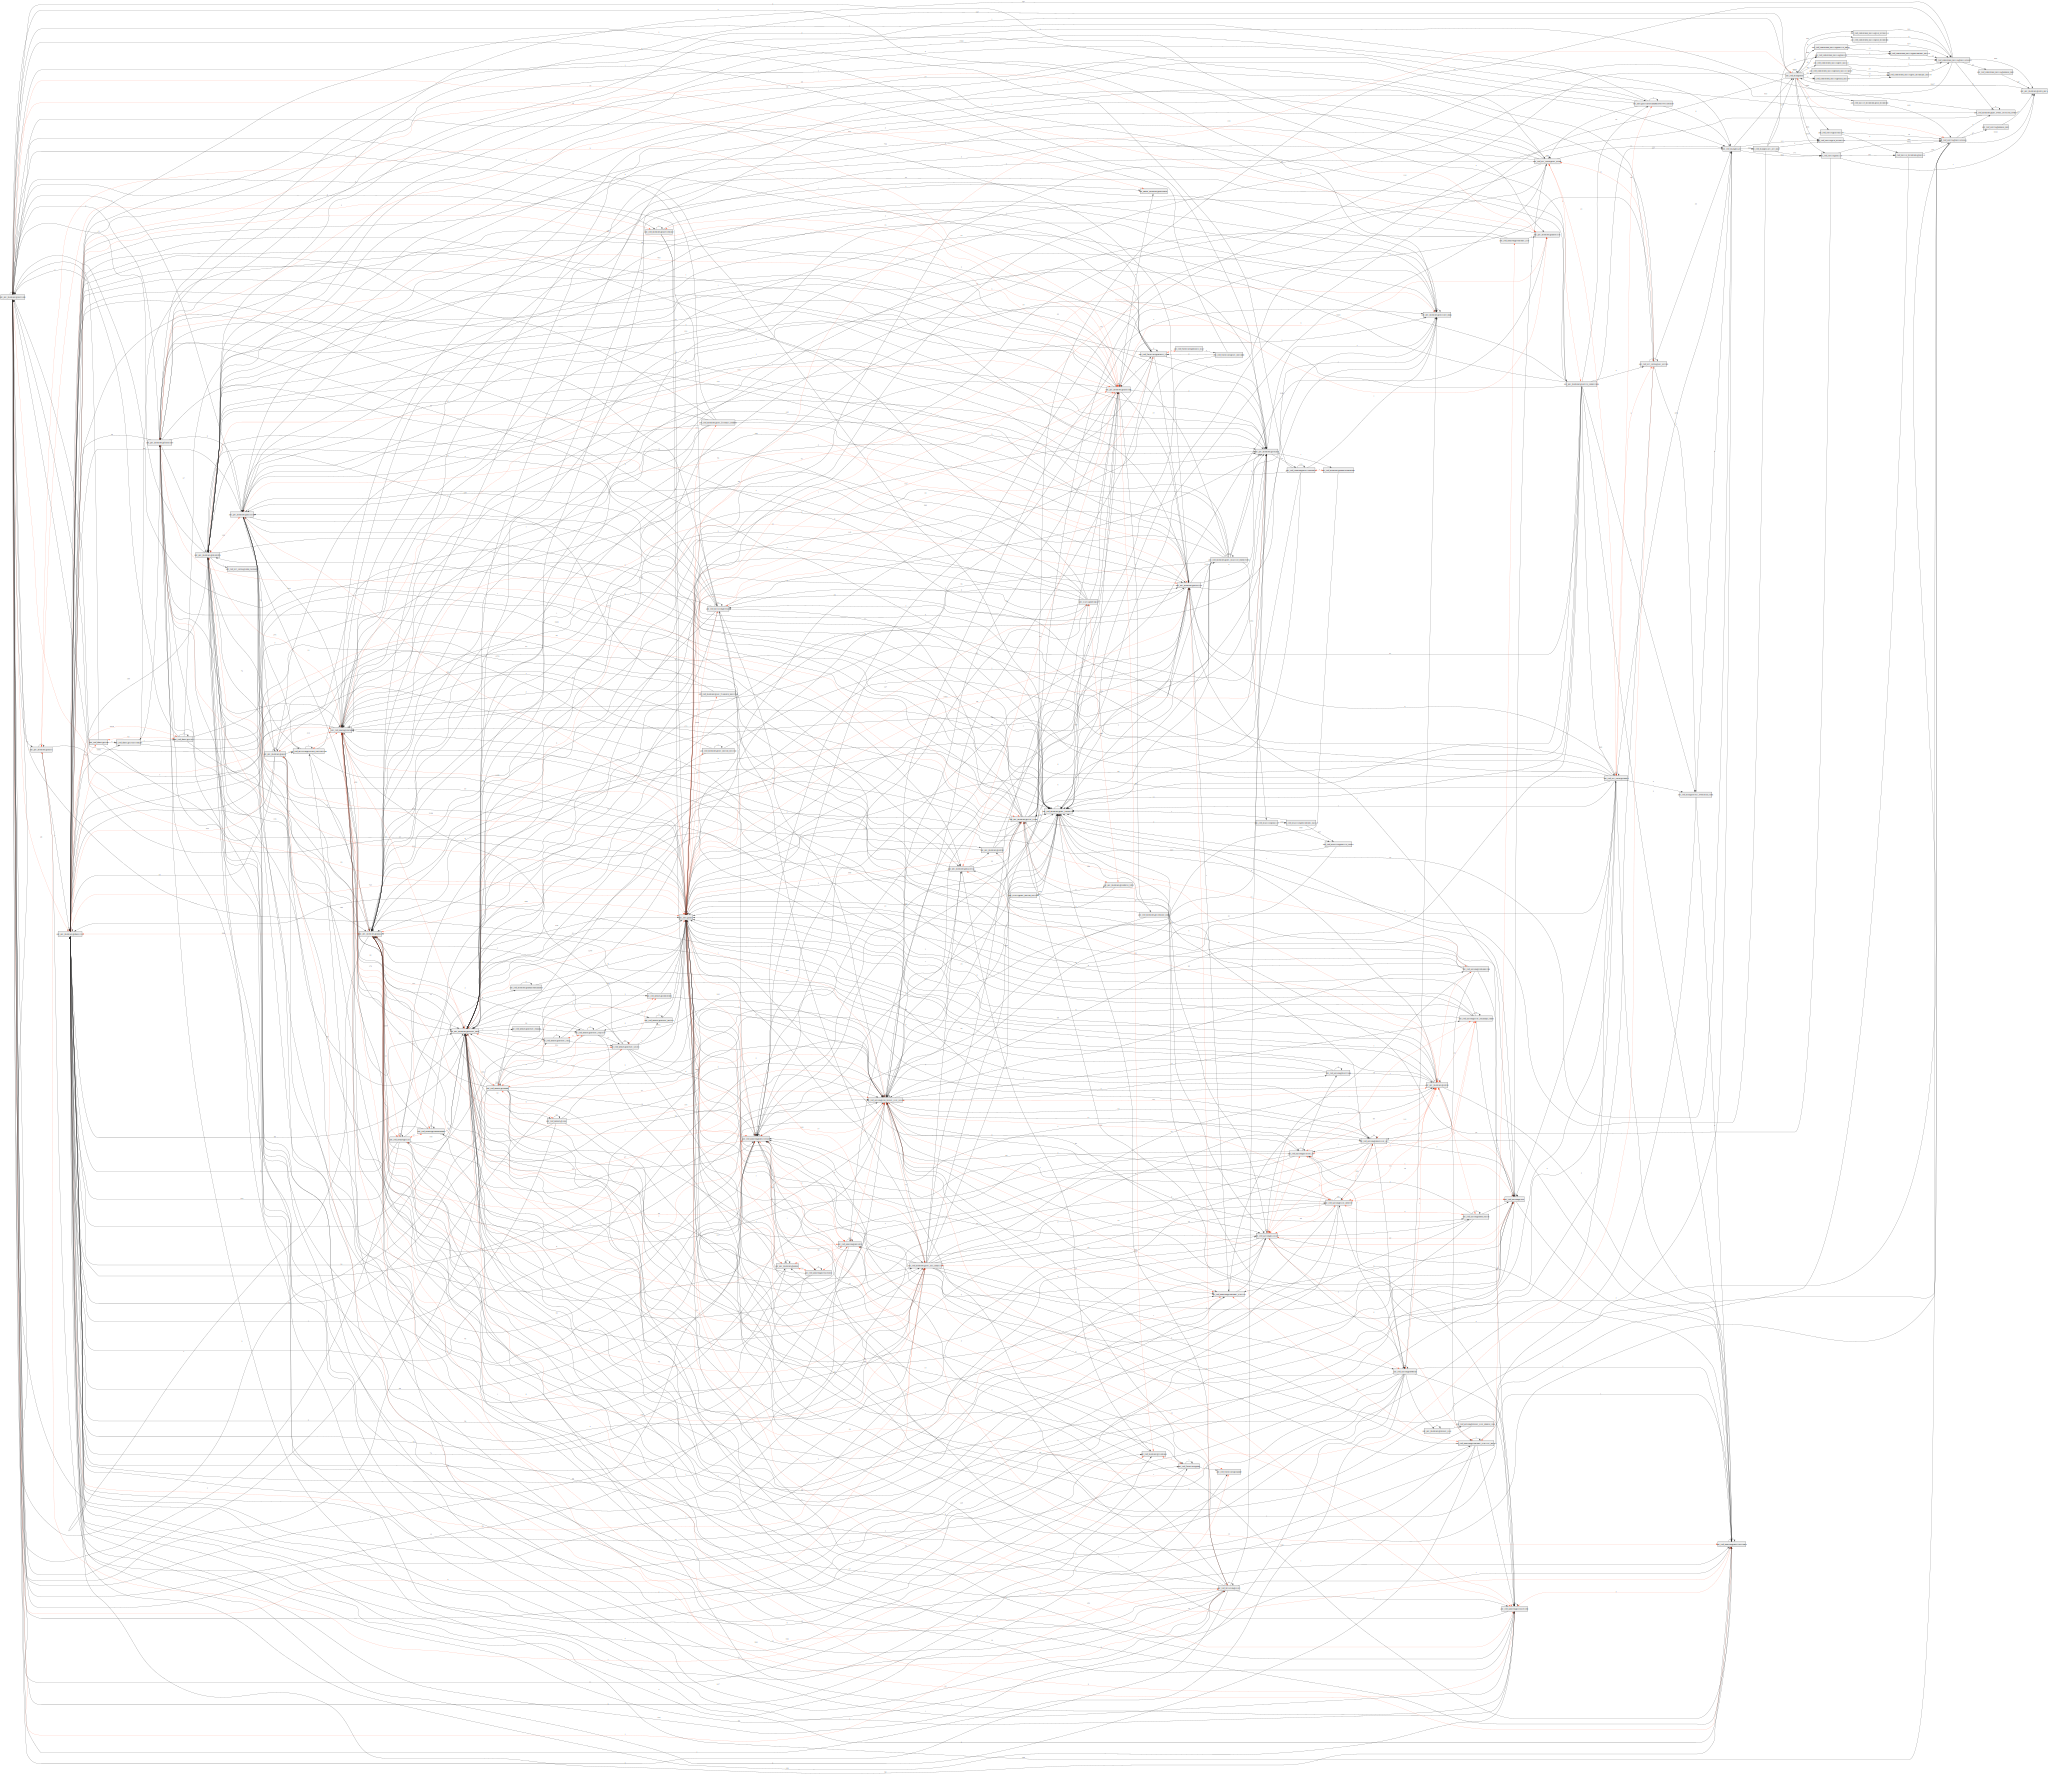

In [11]:
import graphviz
from IPython.display import display

file_list =  extract_and_process_filenames(TARGET_DIR, FILENAME_REGEX)
sequences = divide_into_sequences(file_list)
dot_output = generate_state_transition_diagram_dot(sequences)

graph_source = graphviz.Source(dot_output)
display(graph_source)